# **Preliminary data analysis**

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sb
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer

Задание 1: Детекция аномалий в данных кредитного скоринга

Используйте набор данных кредитного скоринга с Kaggle ([ссылка на данные](https://www.kaggle.com/mlg-ulb/creditcardfraud)) и определите аномалии в данных, используя Z-score или IQR.


In [3]:
data = pd.read_csv('data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0.0
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0.0
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0.0
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0.0
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0.0


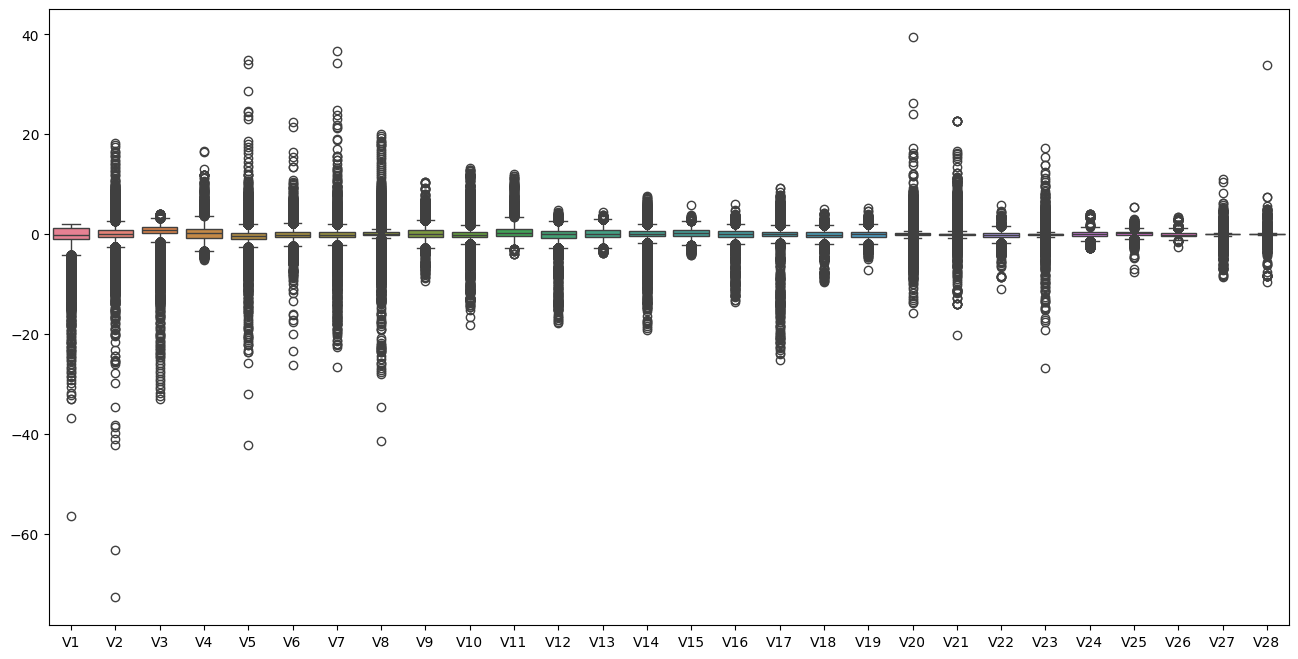

In [4]:
plt.figure(figsize=(16, 8))
sns.boxplot(data.iloc[:, 1:29])
plt.show()

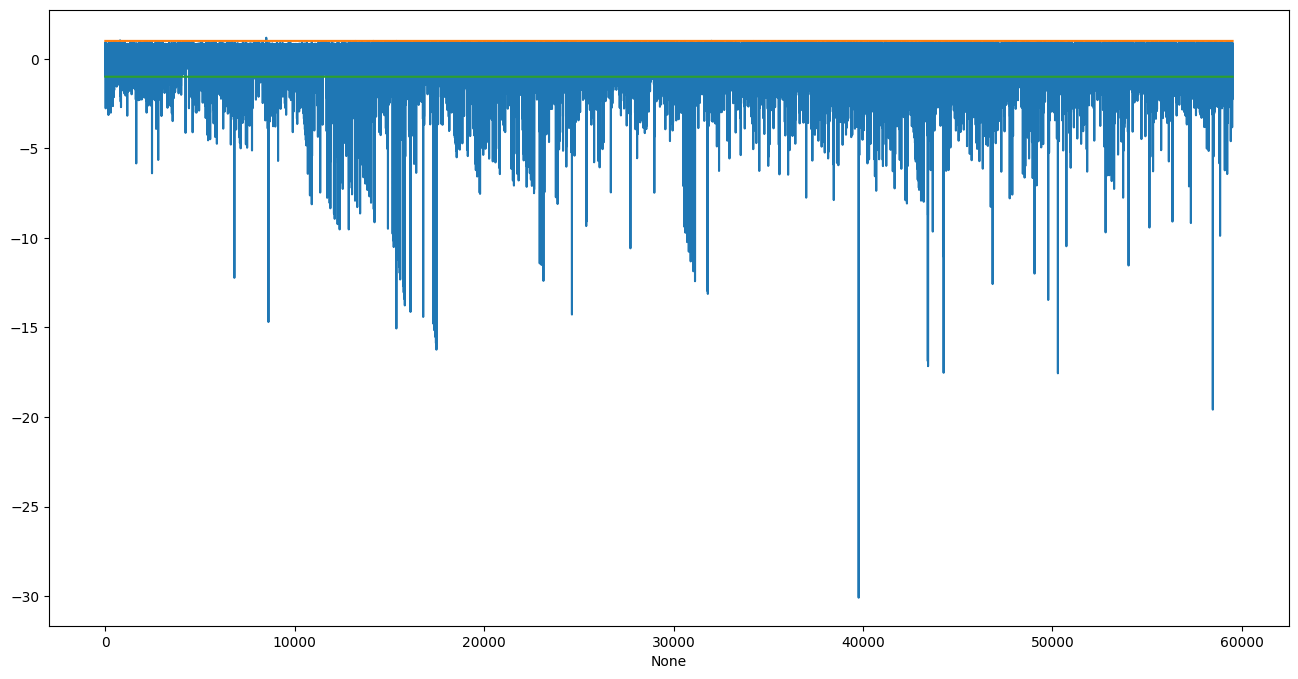

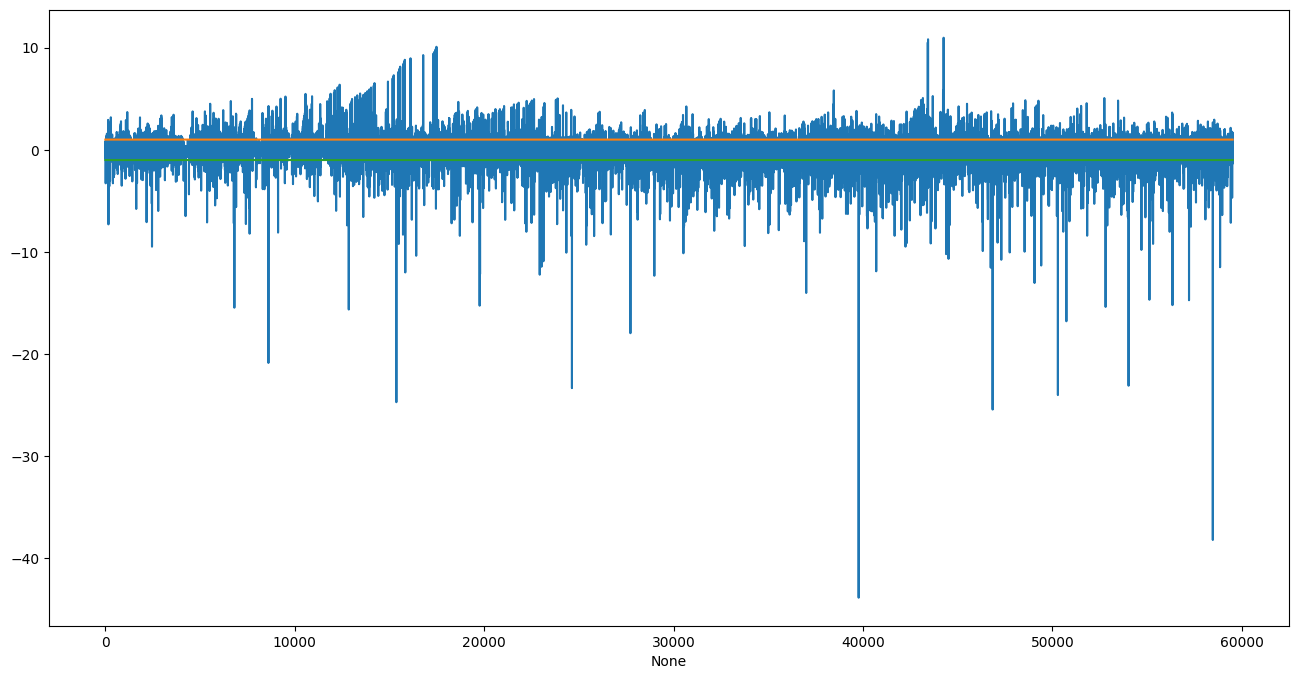

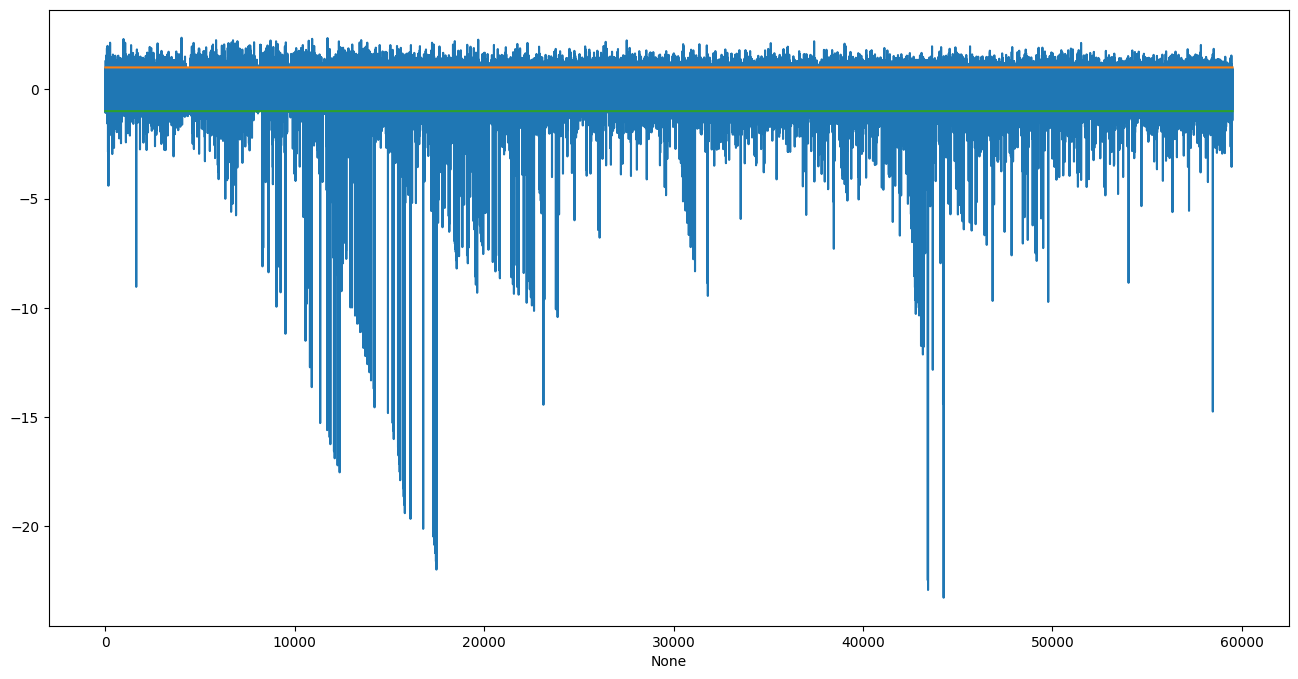

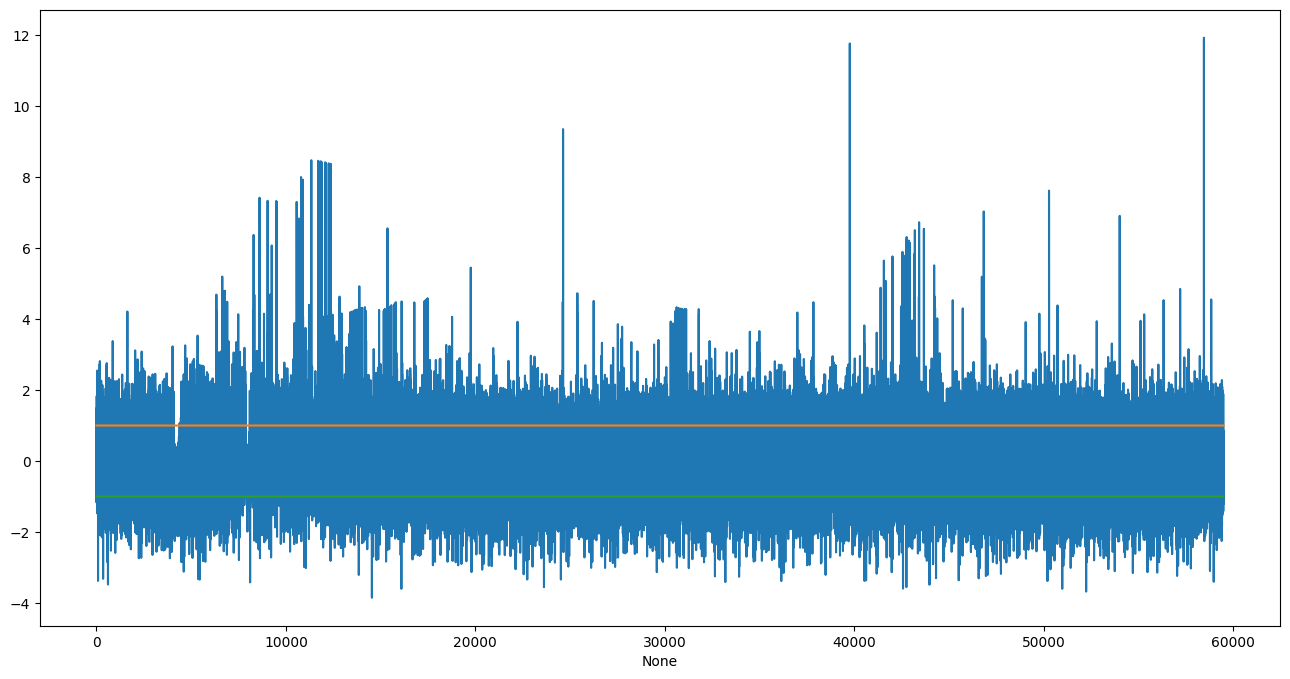

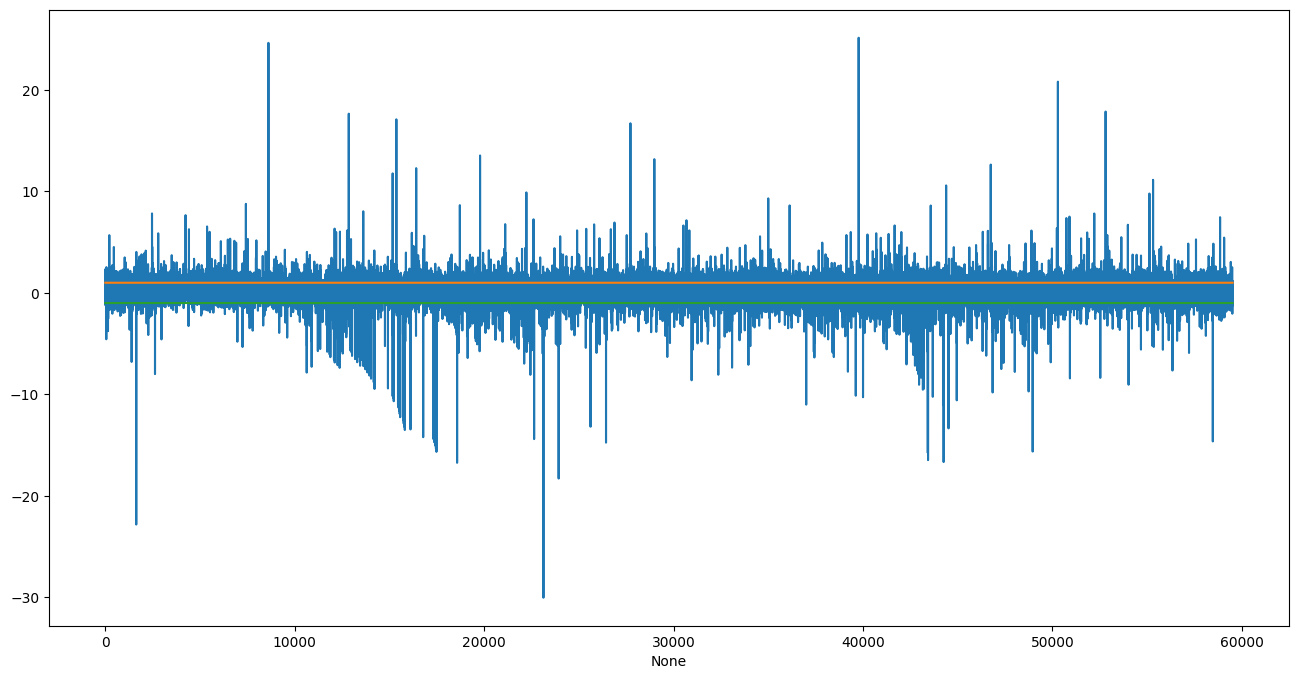

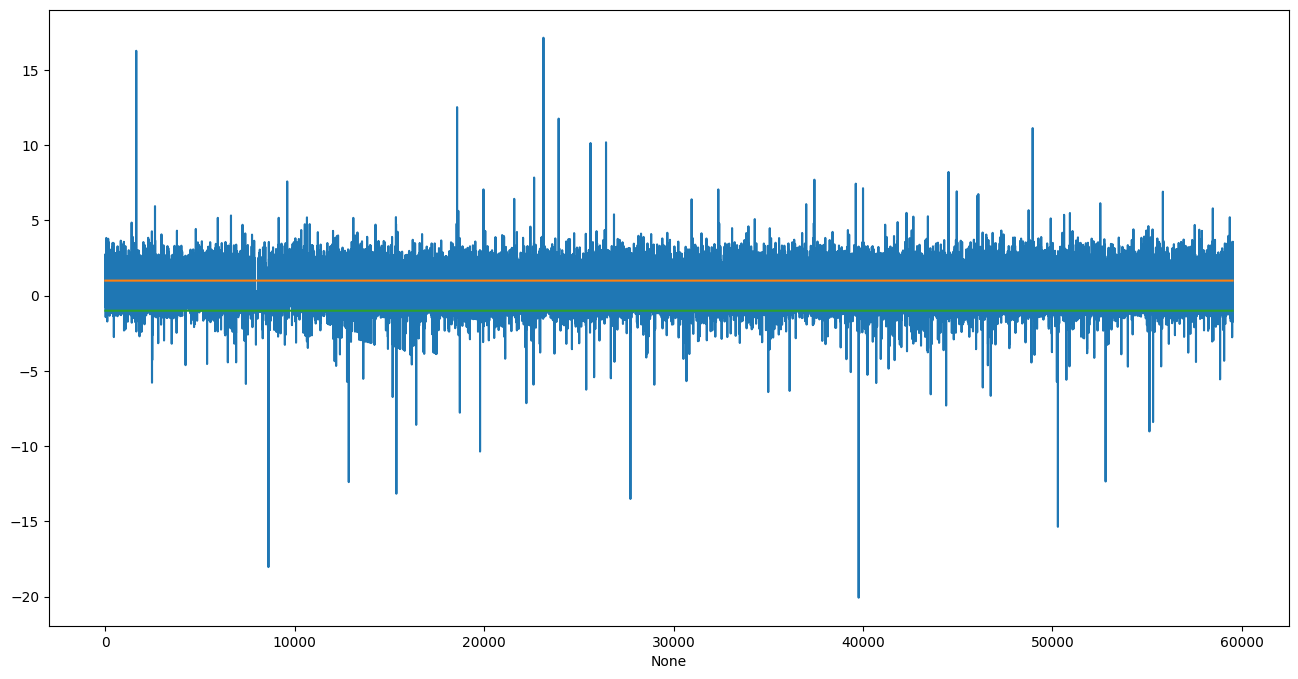

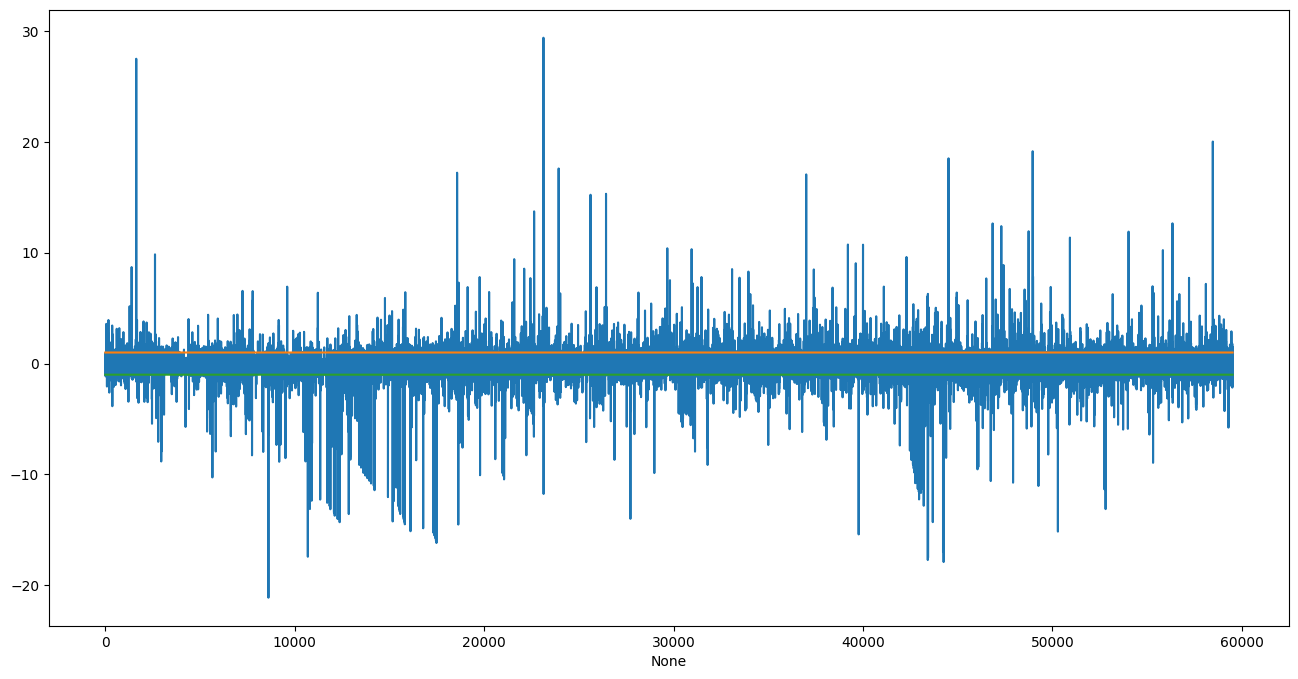

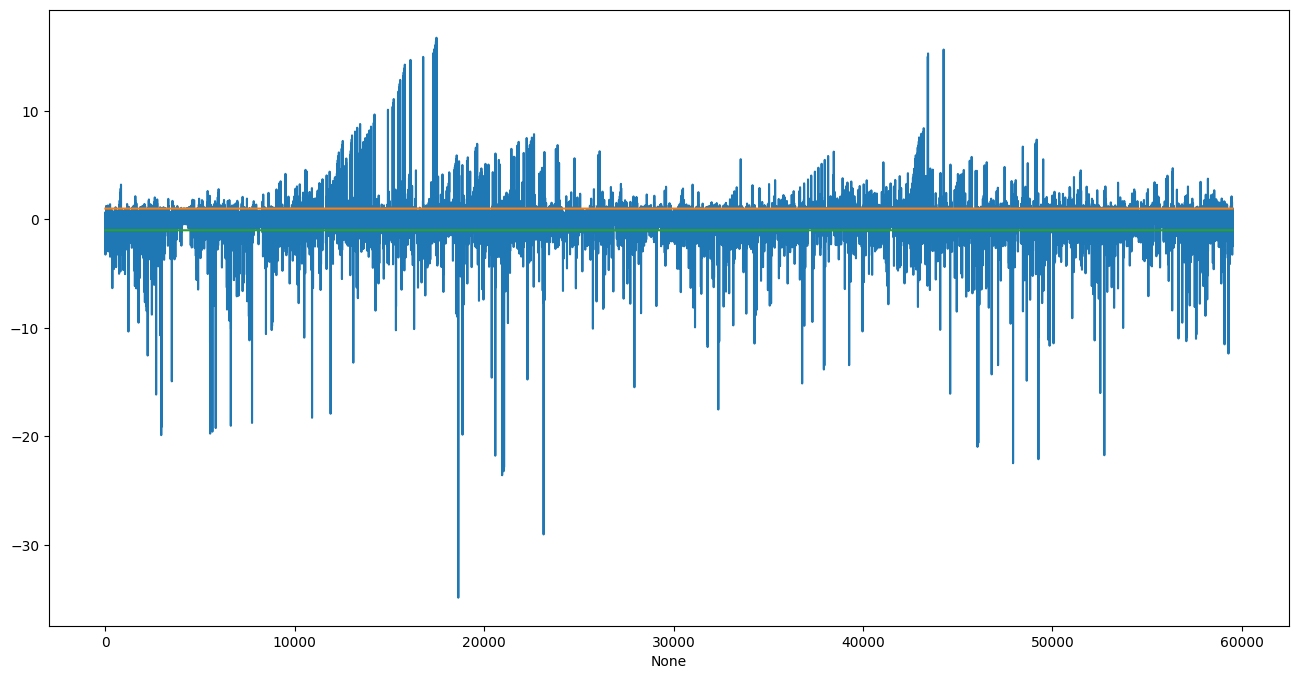

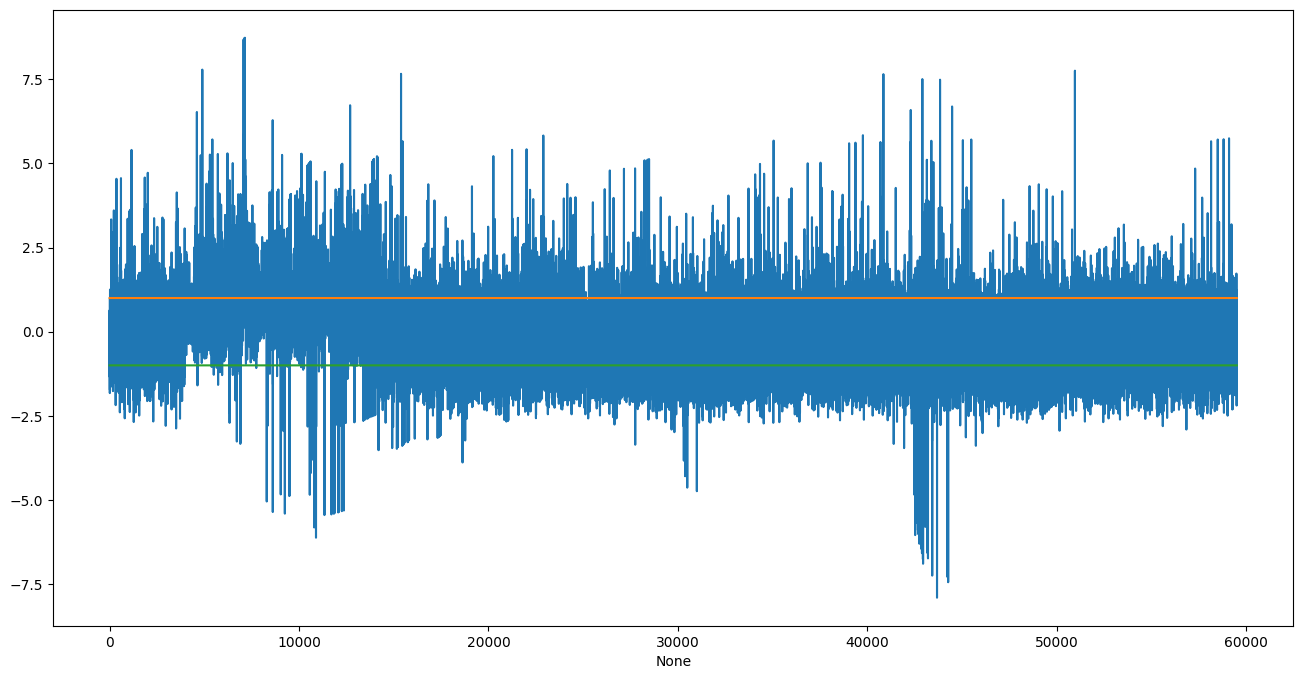

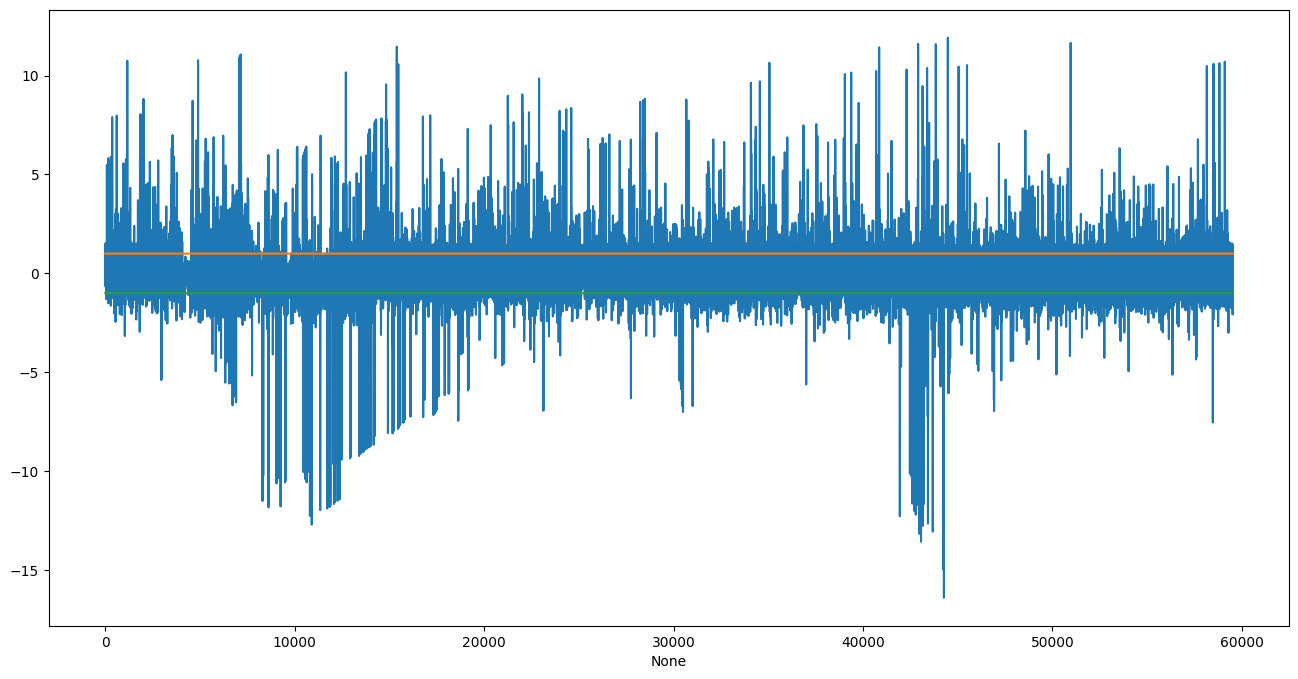

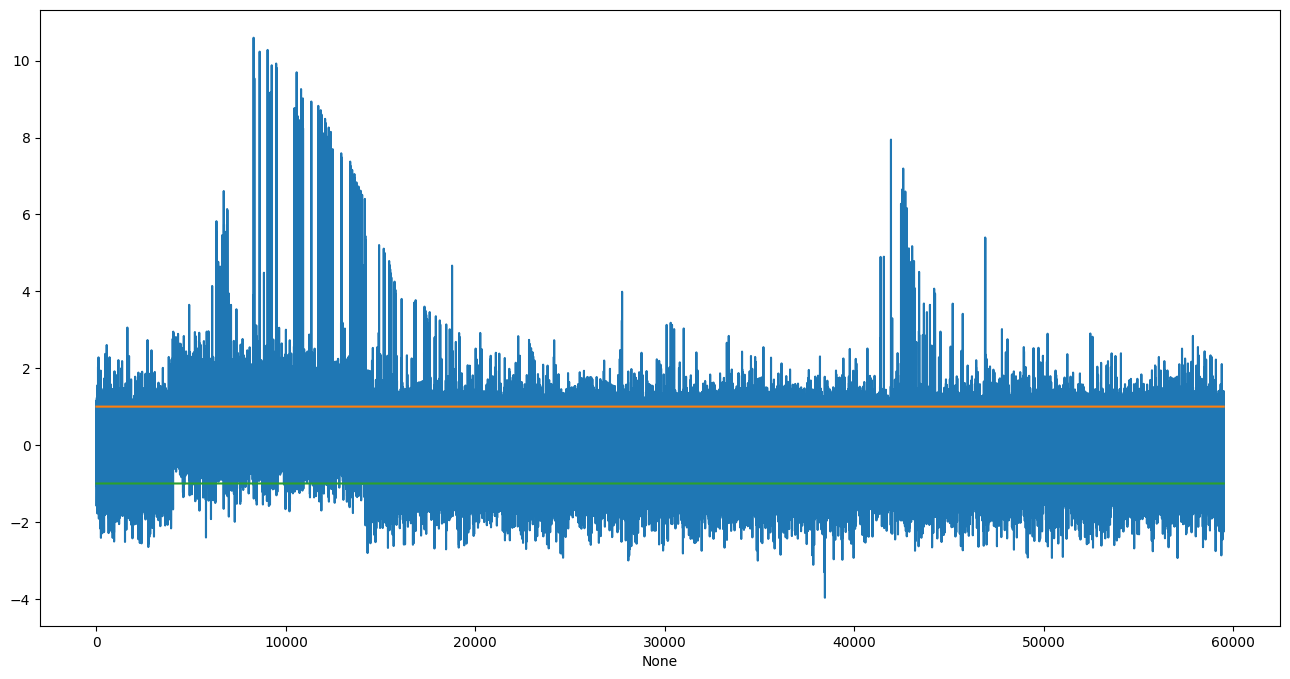

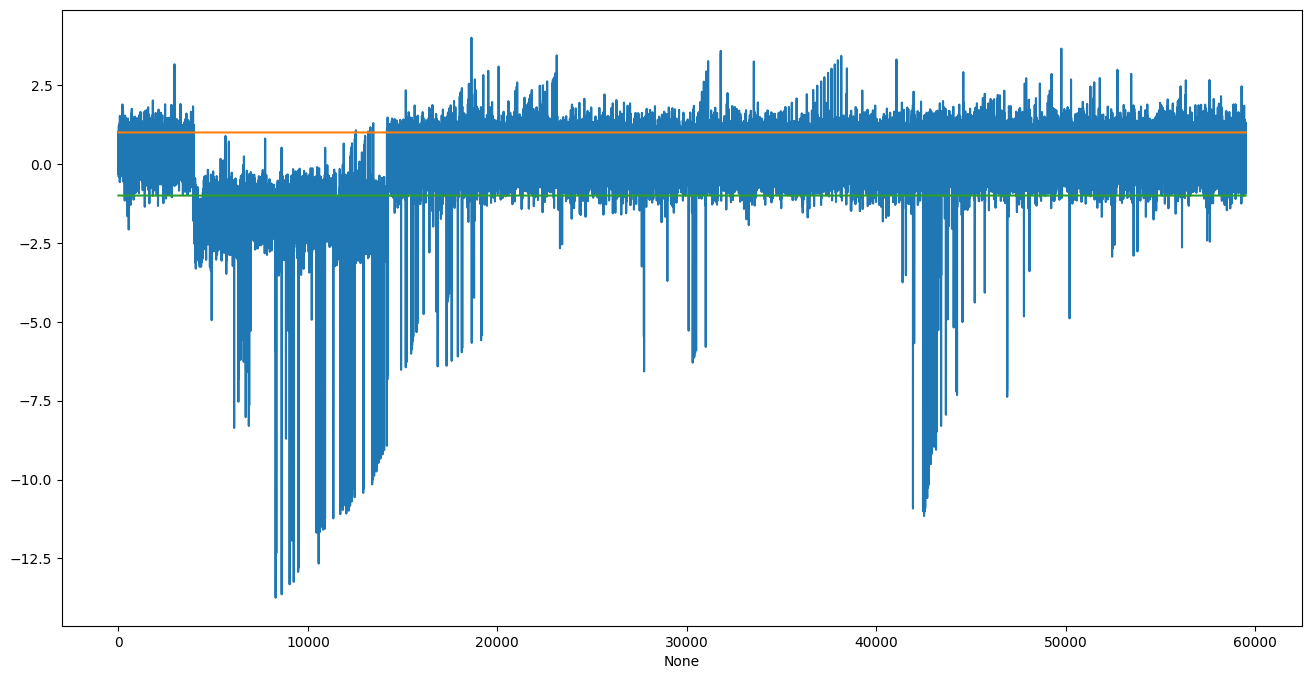

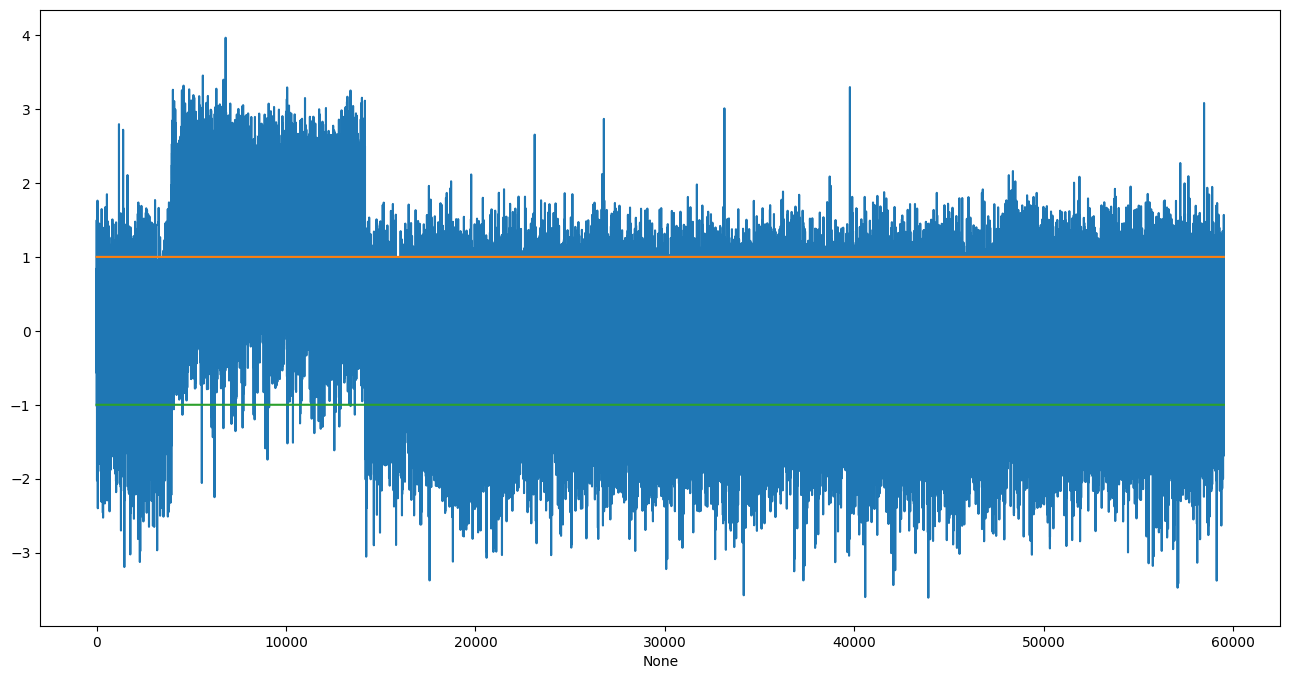

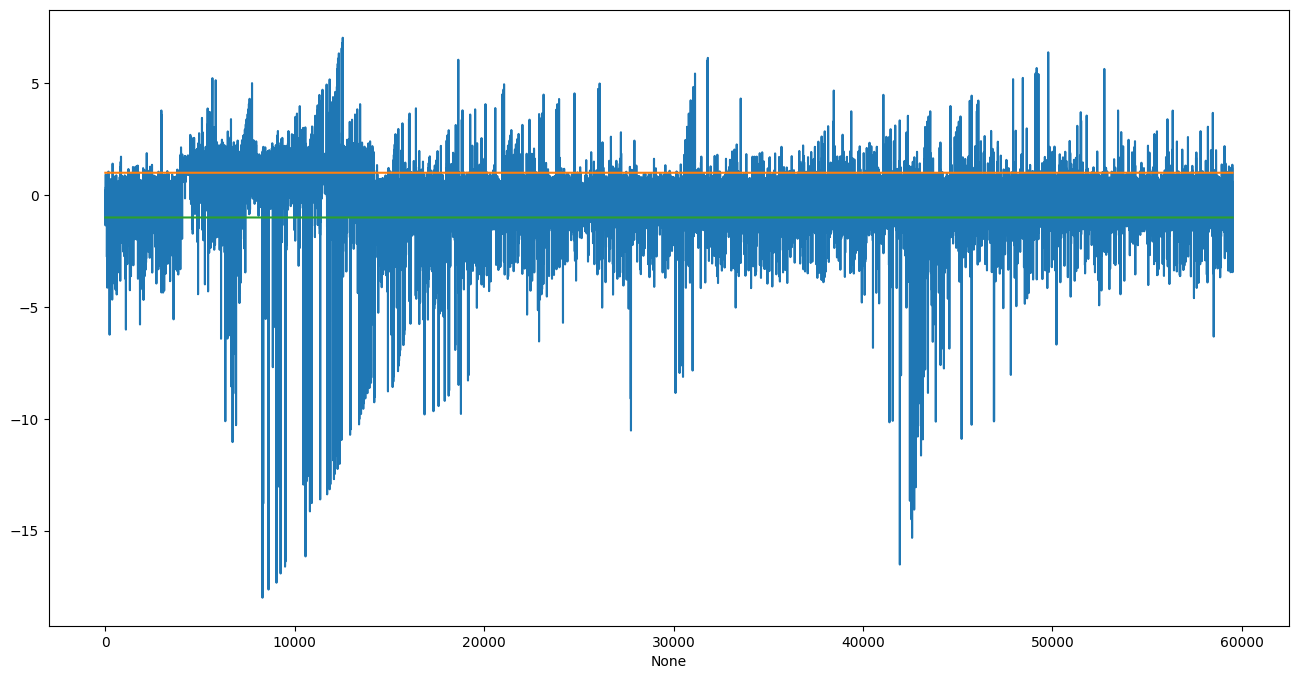

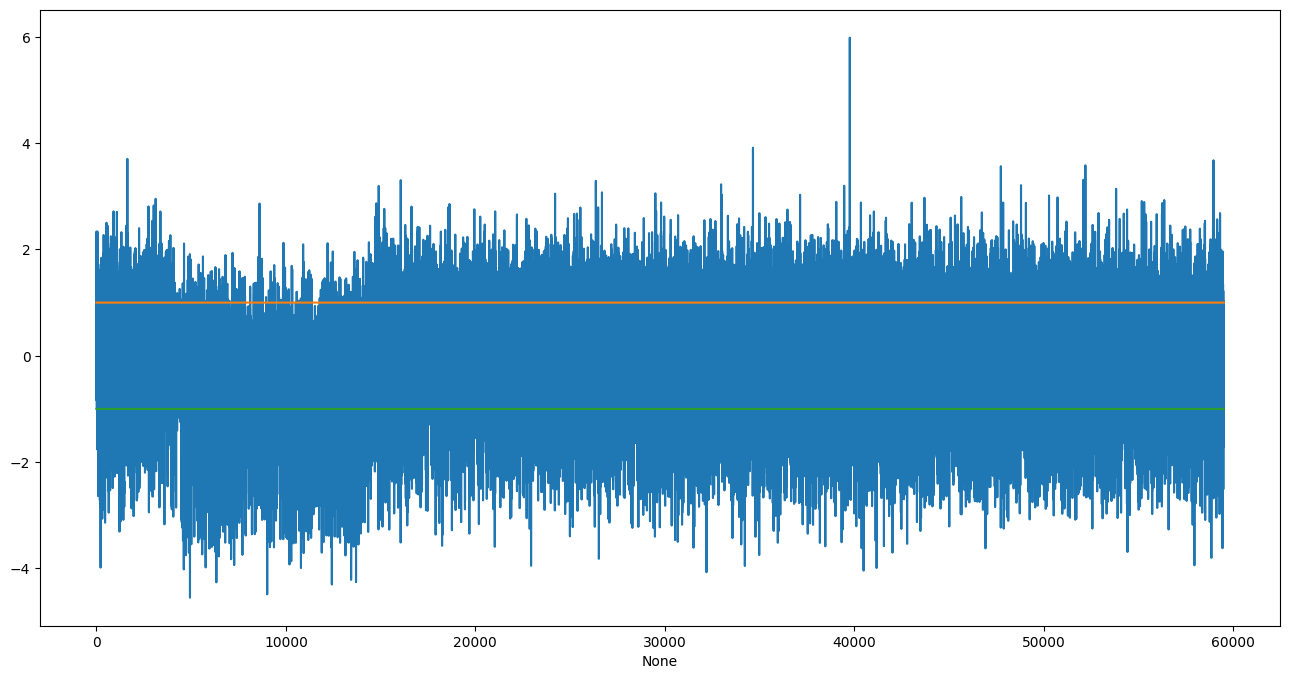

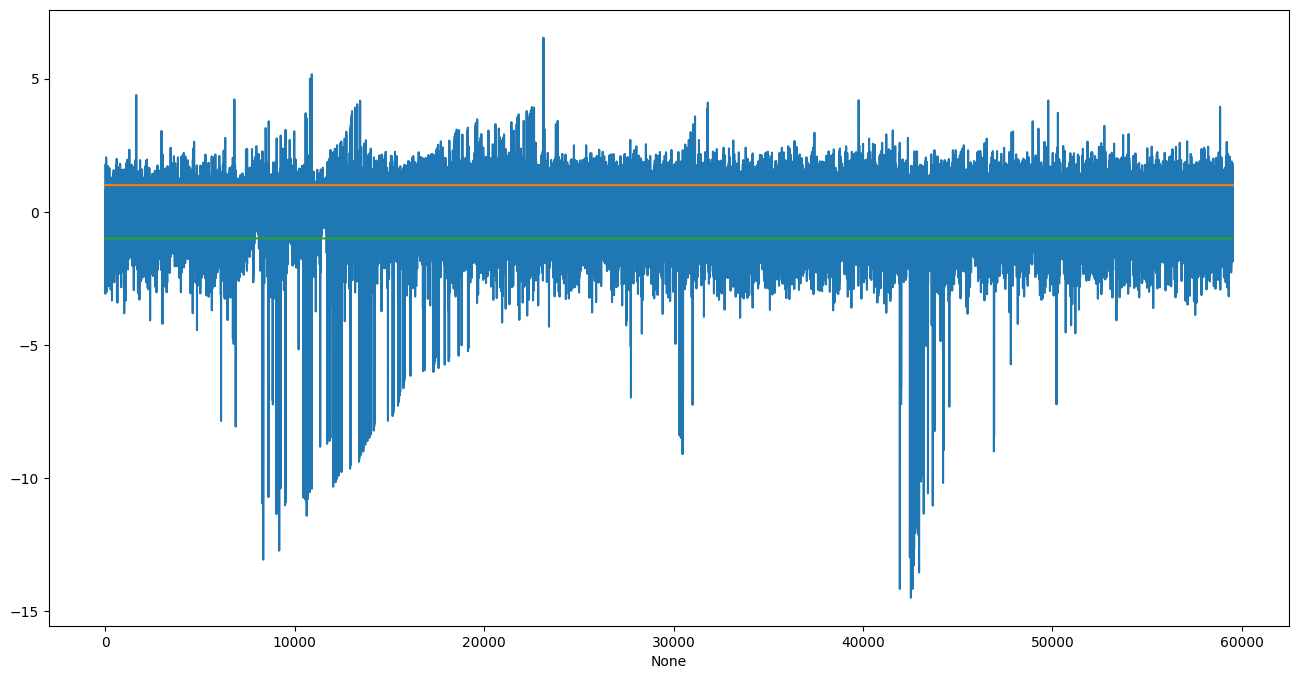

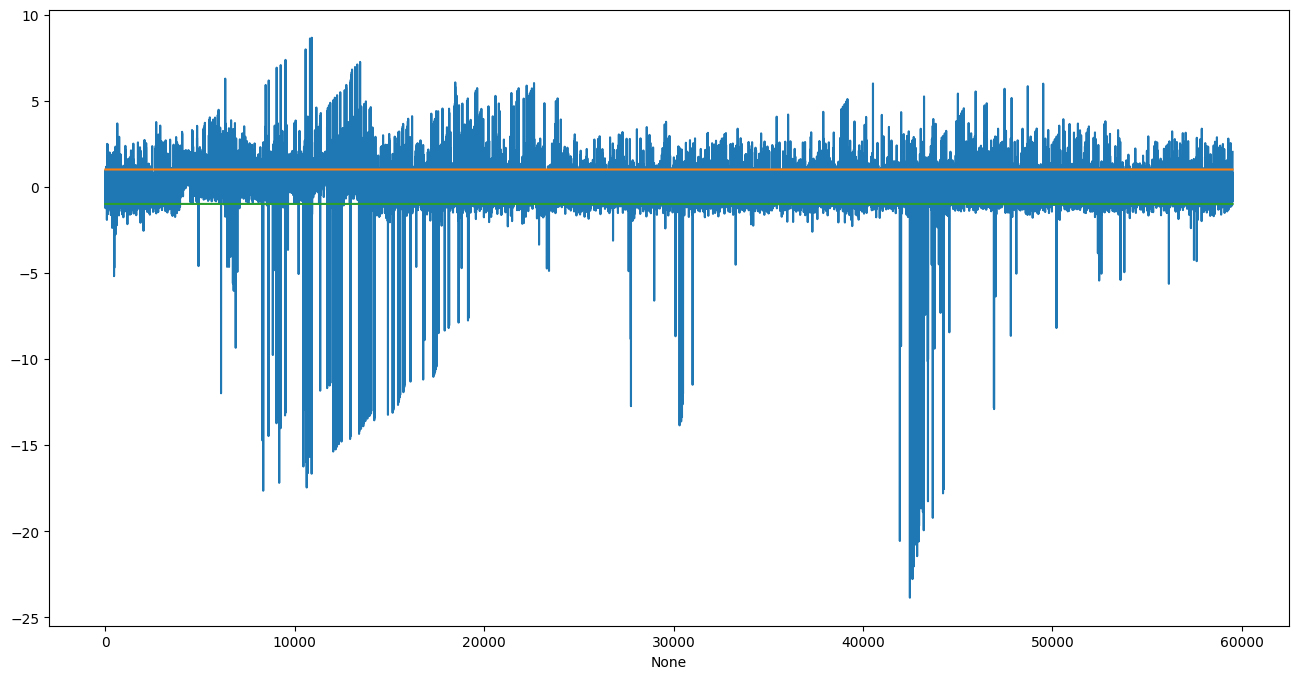

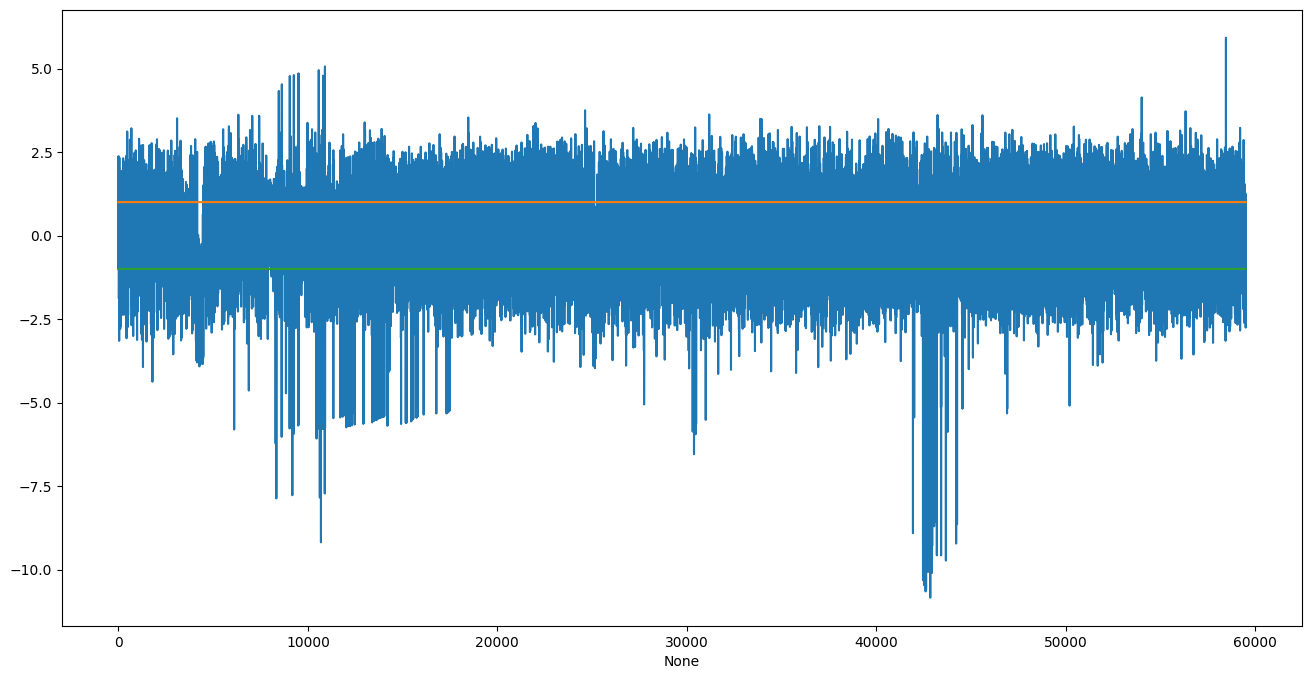

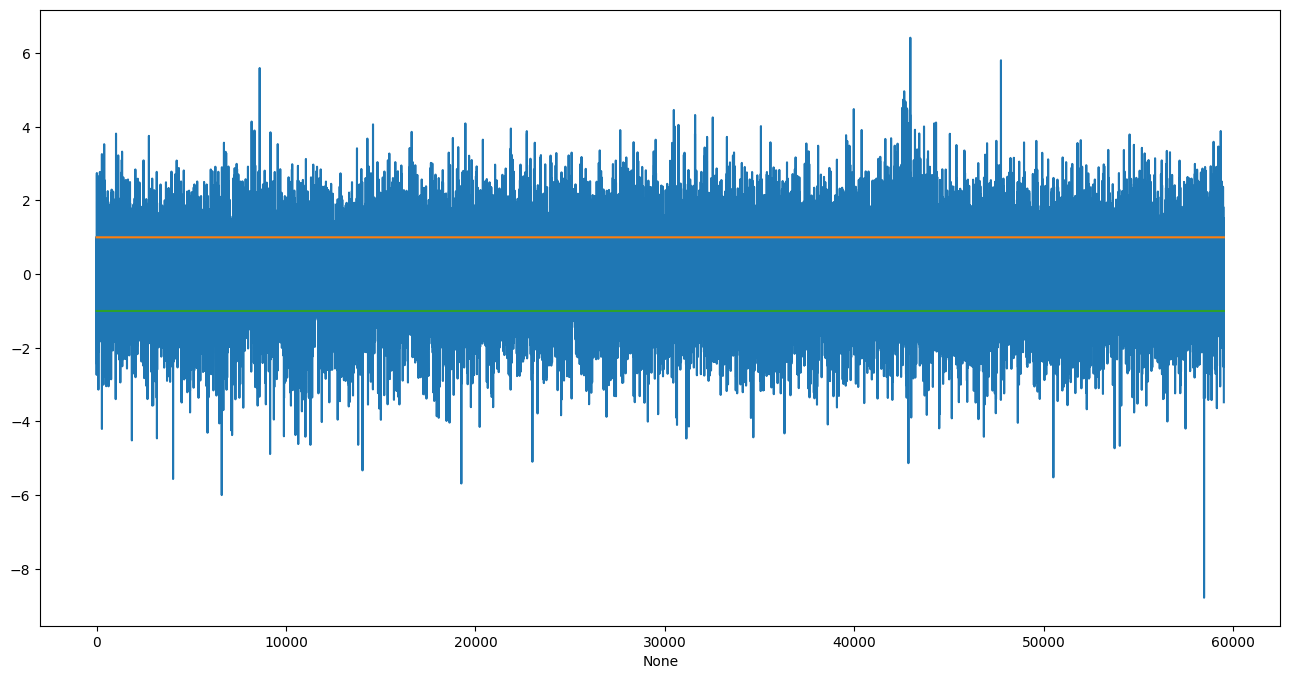

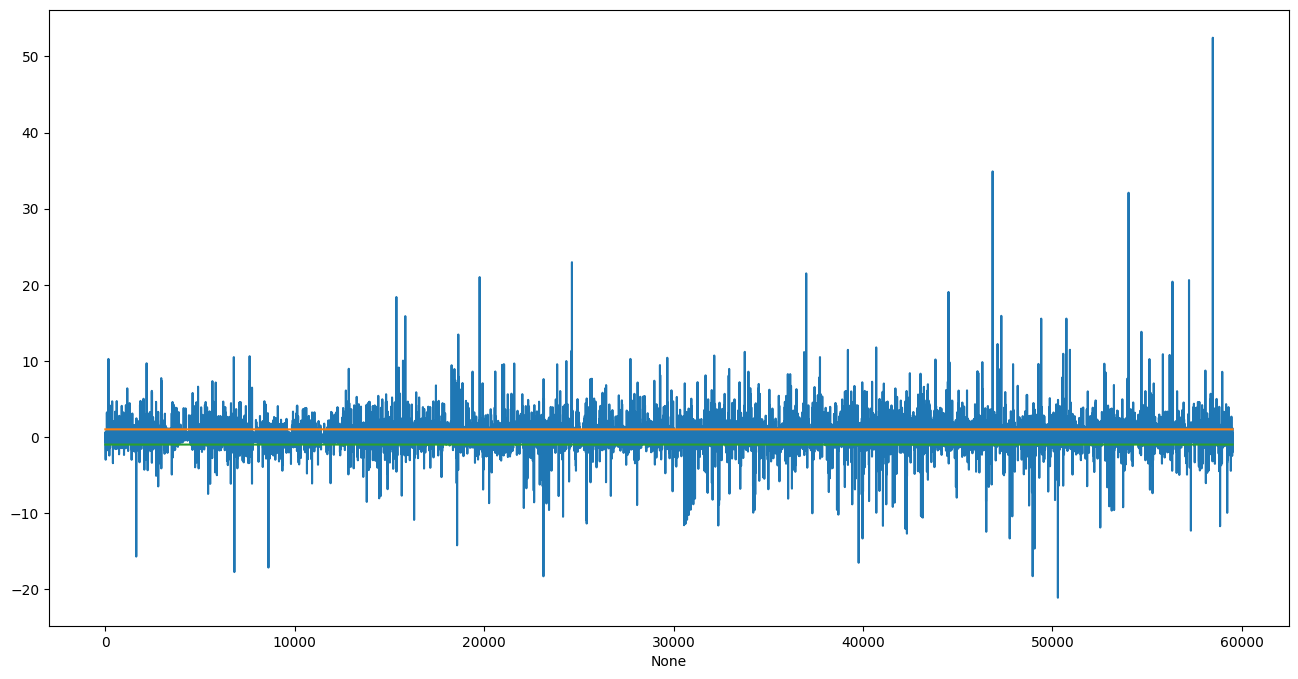

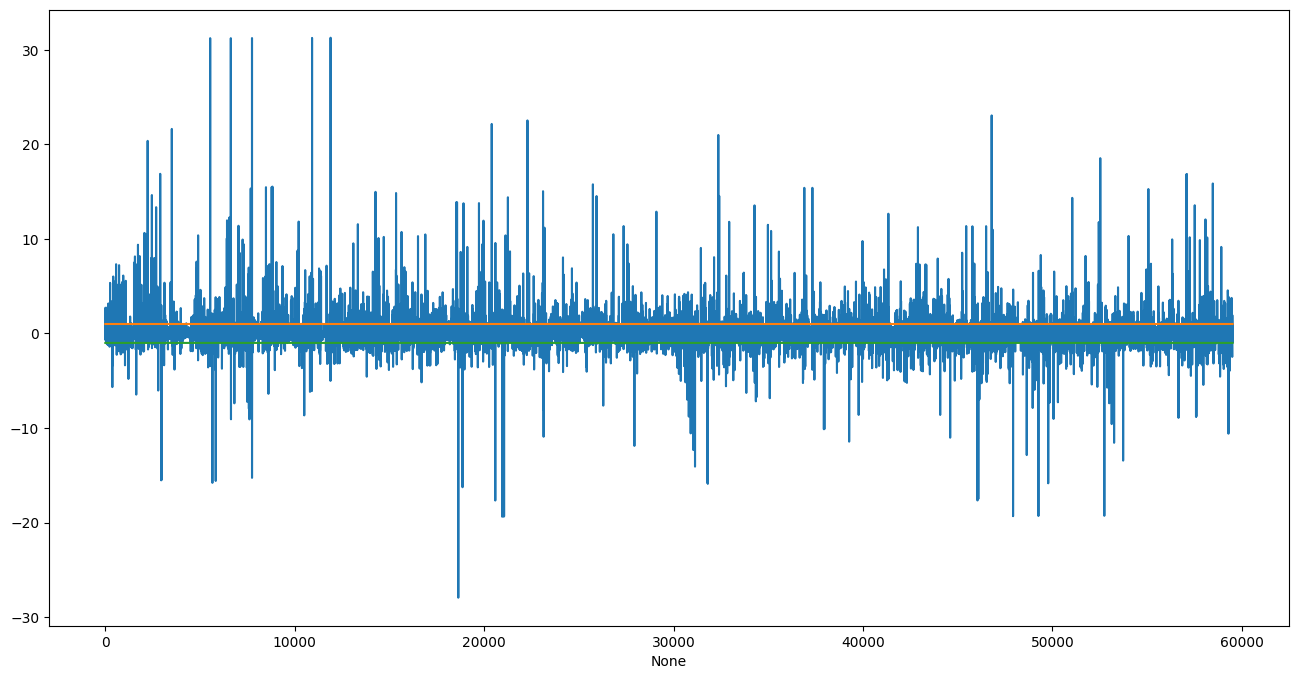

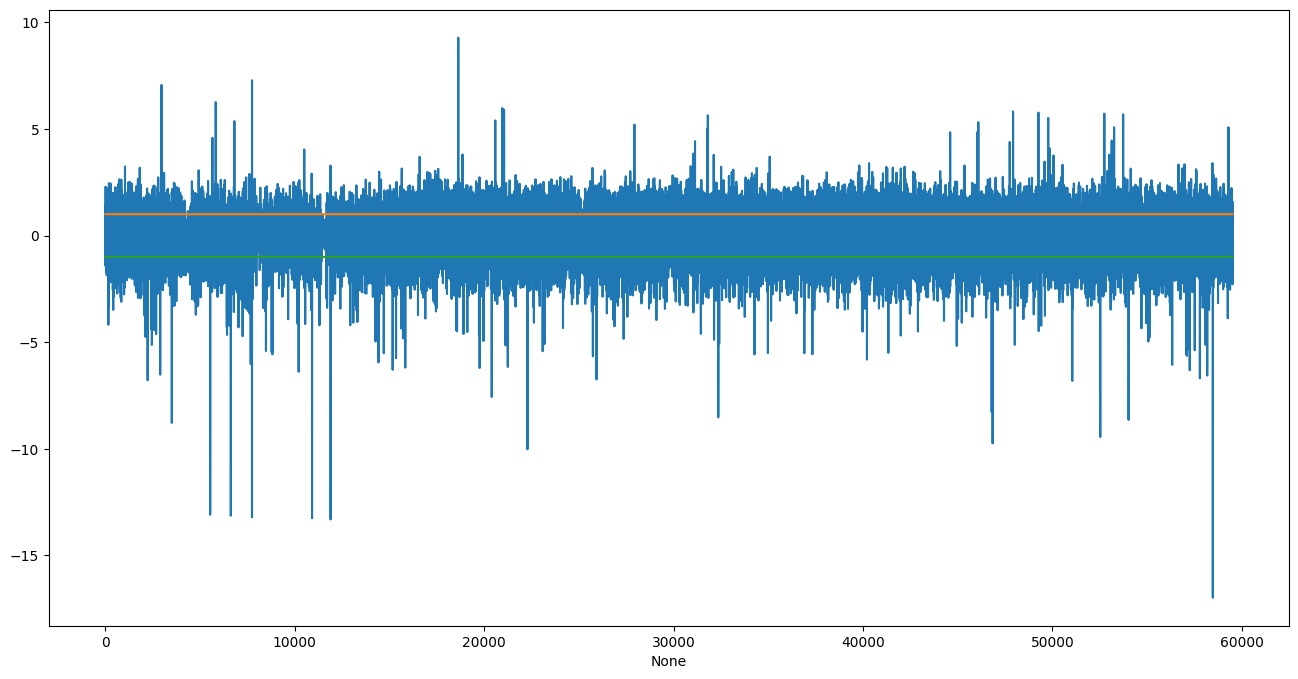

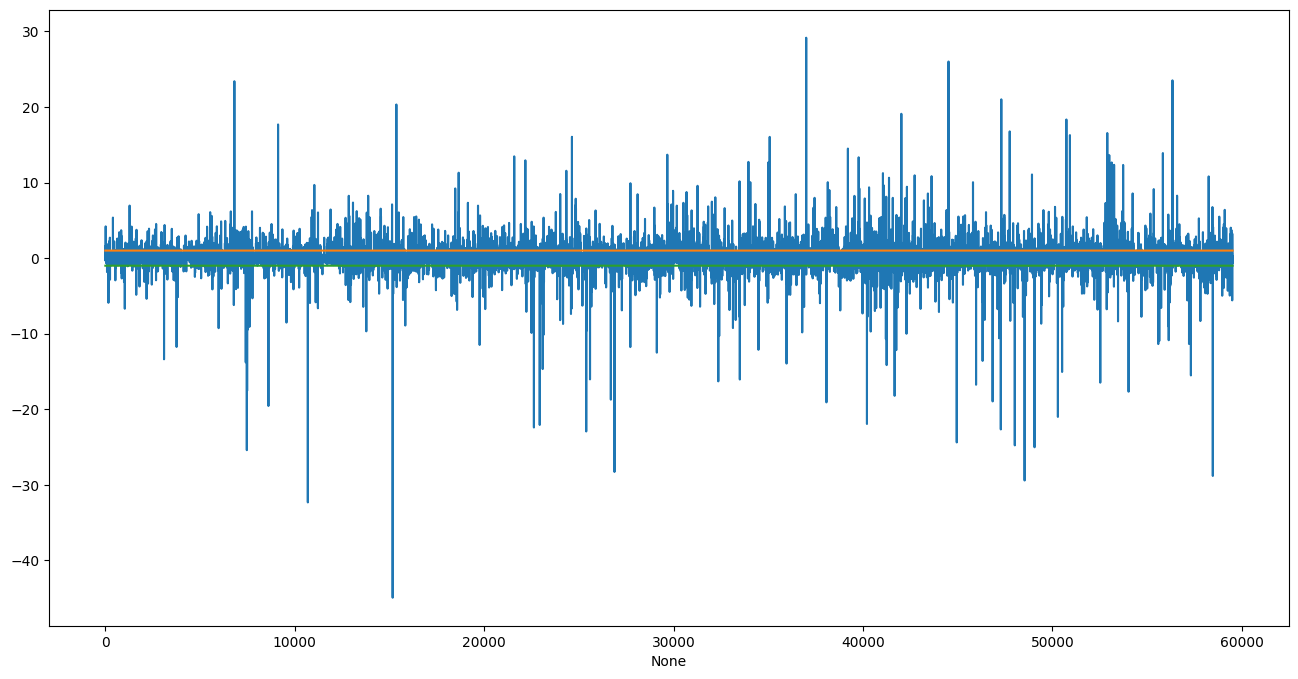

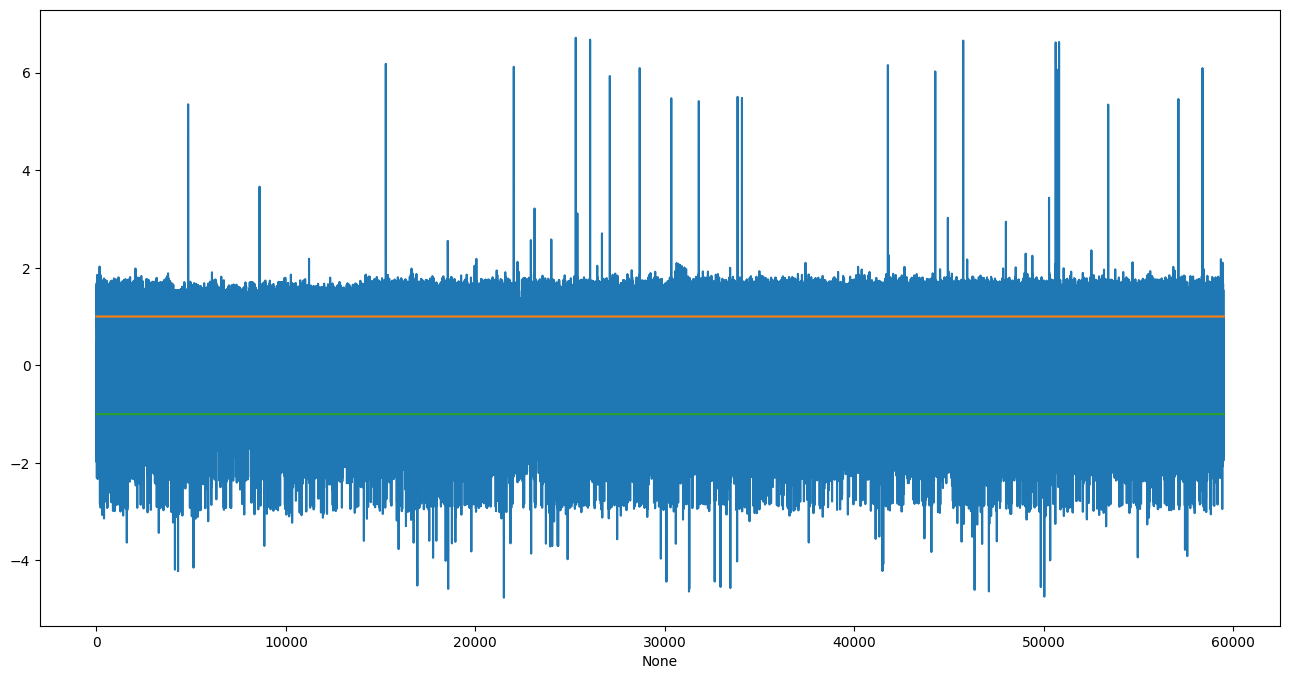

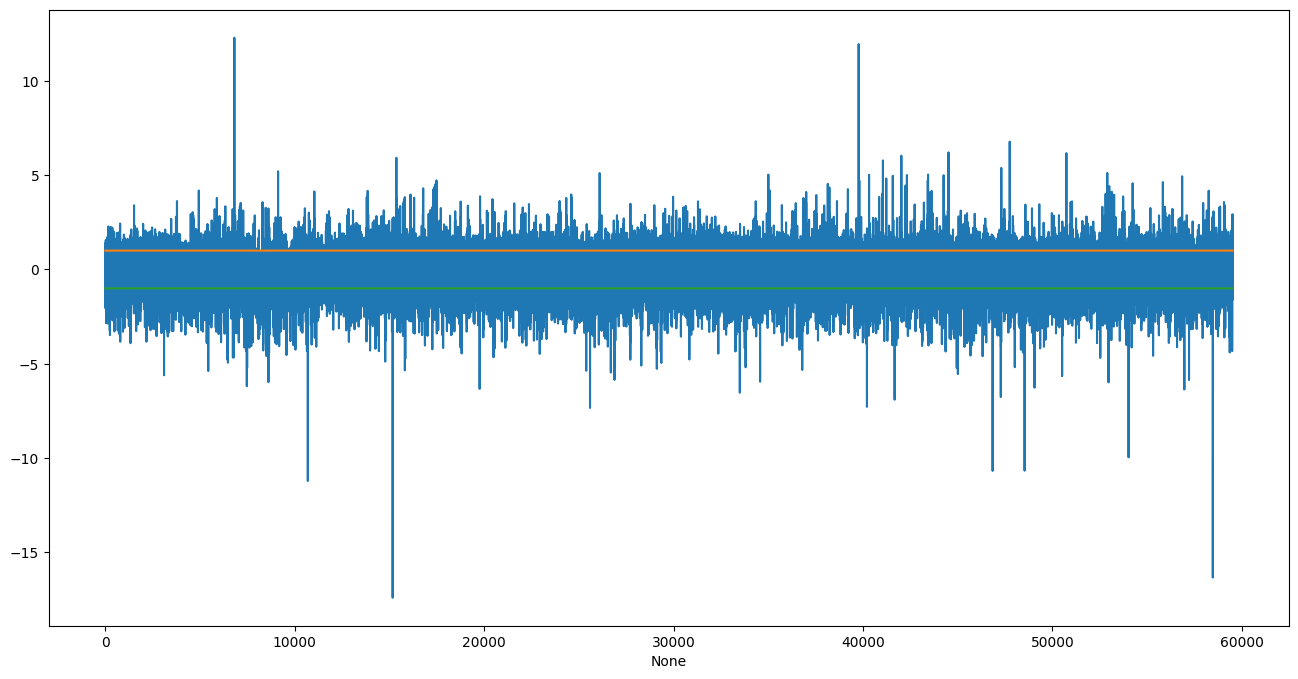

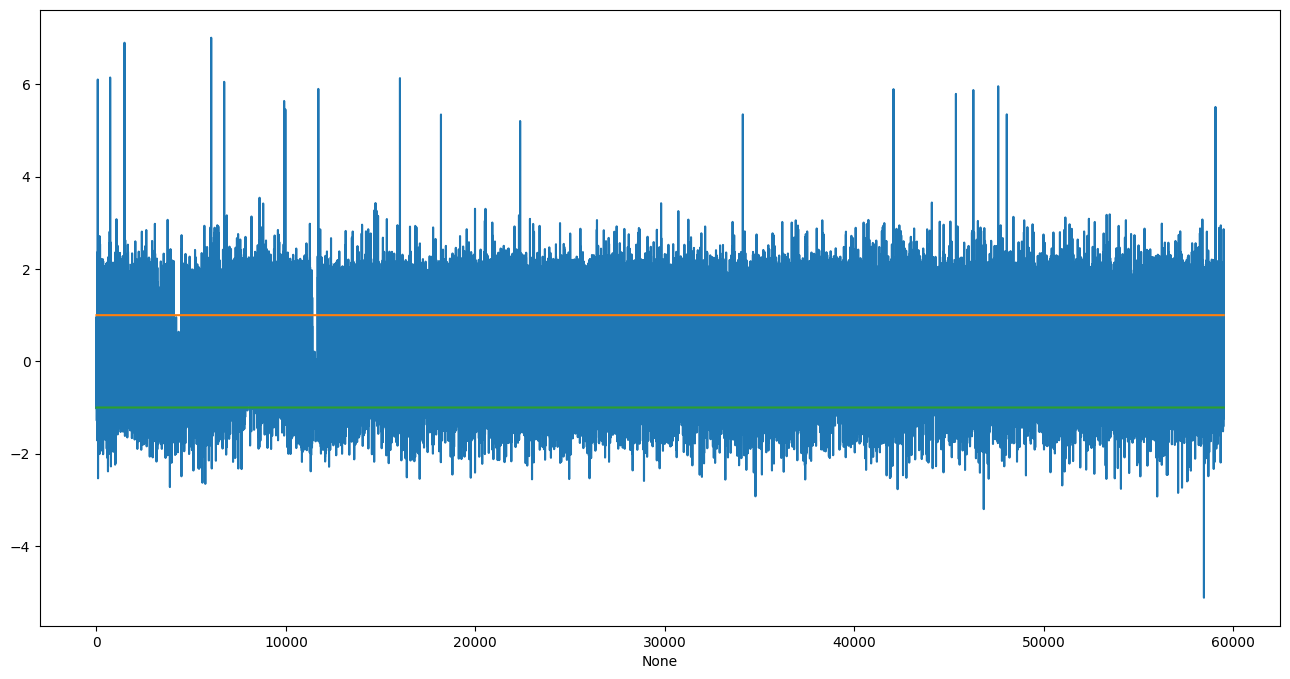

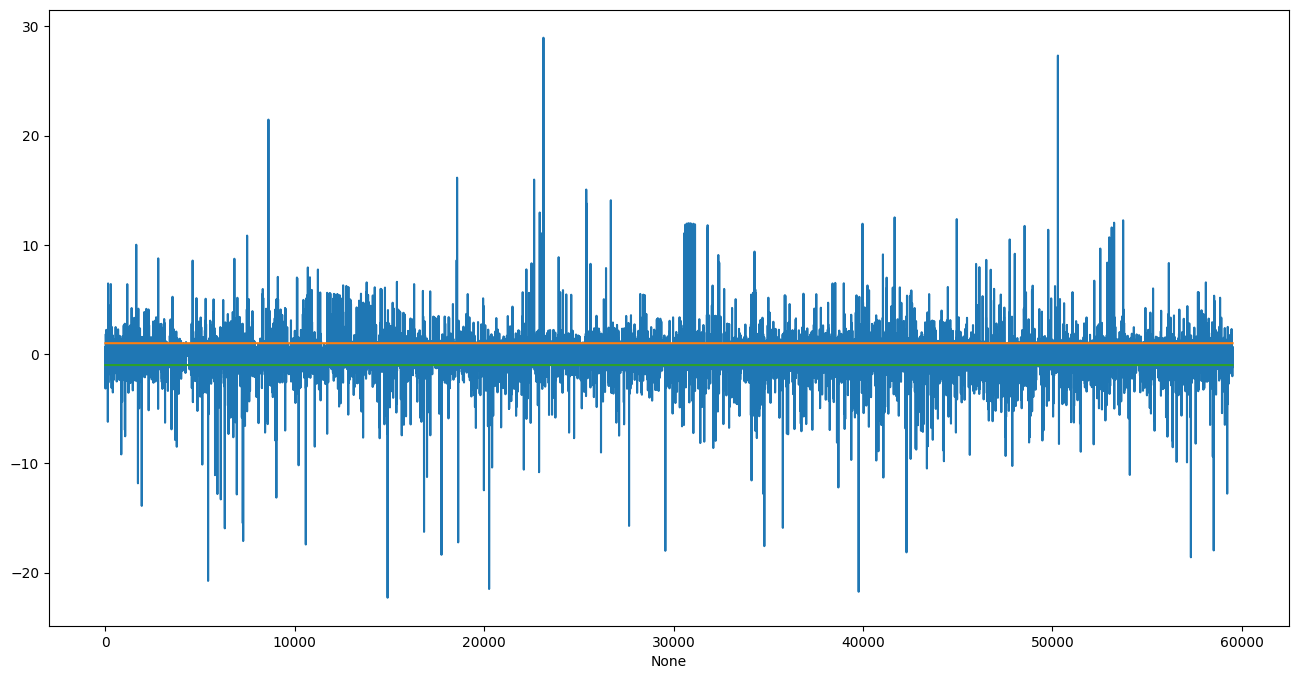

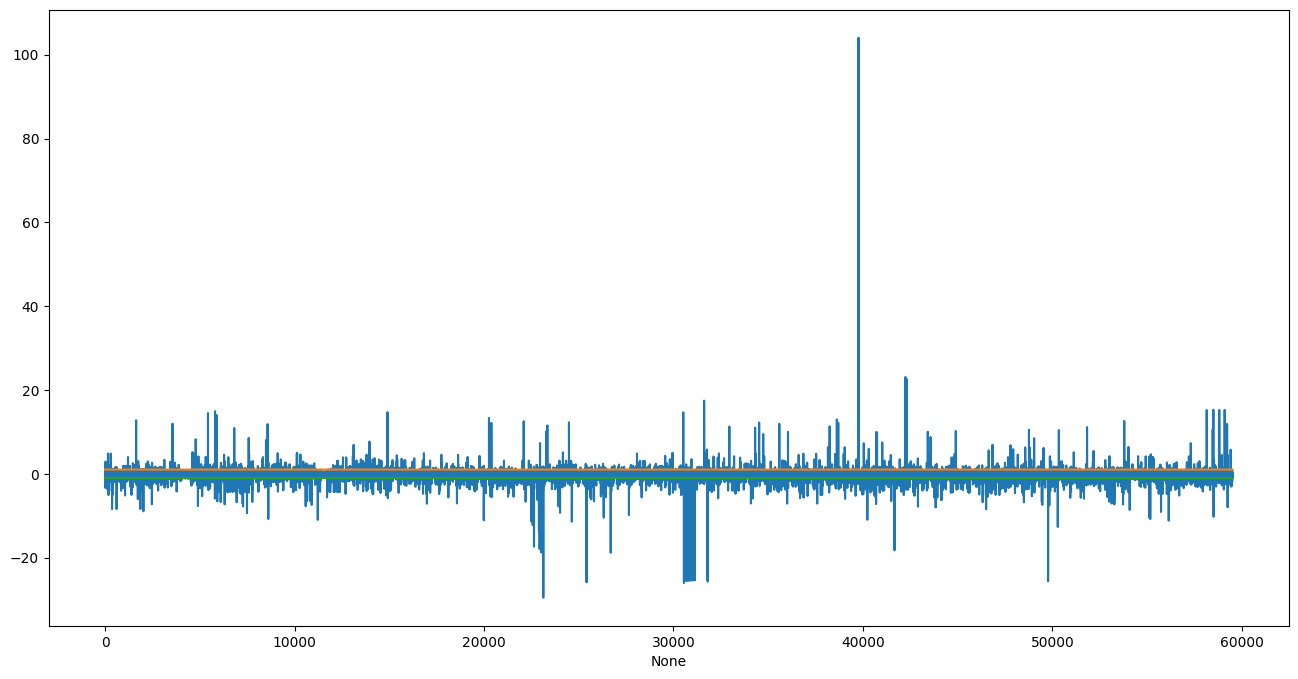

In [5]:
for column_name in data.columns[1:29]:
    plt.figure(figsize=(16, 8))
    plt.plot((data[column_name]-data[column_name].mean())/data[column_name].std())
    sns.lineplot(x=data.index, y=1)
    sns.lineplot(x=data.index, y=-1)
    plt.show()

Let's Upload data and Delete unnecessary columns

The Z-score helps to identify outliers by comparing the value of a feature with its mean and standard deviation. If Z is the score significantly exceeds the threshold, the value is considered an anomaly.
A function for detecting outliers based on a Z-score

In [34]:
data_1 = pd.read_csv('data/creditcard.csv')
data_1_cleaned = data_1.drop(columns=['Time', 'Amount', 'Class'])

In [35]:
def detect_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = (z_scores > threshold)
    return np.where(outliers)

# Applying Z-score
outliers_z = detect_outliers_zscore(data_1_cleaned)

The Interquartile range (IQR) is a method that uses distance between the first and third quartiles to identify outliers.

 Values, which significantly exceed IQR limits are considered anomalies.

 IQR-based outlier detection function

In [36]:
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    return outliers

# Applying IQR
outliers_iqr = detect_outliers_iqr(data_1_cleaned)

Calculating the number of anomalies based on the Z-score

In [37]:
def count_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    outliers = np.where(z_scores > threshold)
    unique_outliers = np.unique(outliers[0])  # Getting indexes of rows with outliers
    return len(unique_outliers)

Calculating the number of anomalies based on IQR

In [38]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR)))
    # Counting rows where at least one value is an outlier
    outlier_rows = outliers.any(axis=1)
    return outlier_rows.sum()

Let's count the number of anomalies

In [39]:
zscore_outliers_count = count_outliers_zscore(data_1_cleaned)
print(f"Число аномалий по Z-оценке: {zscore_outliers_count}")
iqr_outliers_count = count_outliers_iqr(data_1_cleaned)
print(f"Число аномалий по IQR: {iqr_outliers_count}")

Число аномалий по Z-оценке: 36636
Число аномалий по IQR: 128657


Задание 2: Поиск аномалий в данных кредитного скоринга

Используйте  набор данных кредитного скоринга ([прямая ссылка на данные Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud)) и определите аномалии, используя методы Z-score или IQR.


In [8]:
data_2 = pd.read_csv('data/Summary of Weather.csv')

<ipython-input-8-046595dfbe05>:1: DtypeWarning: Columns (7,8,18,25) have mixed types. Specify dtype option on import or set low_memory=False.
  data_2 = pd.read_csv('data/Summary of Weather.csv')


Let's Extract the necessary columns for anomaly analysis and Replace possible empty values with NaN and delete lines with omissions

In [40]:
data_2_cleaned = data_2[['MaxTemp', 'MinTemp', 'MeanTemp']]
data_2_cleaned = data_2_cleaned.replace('T', np.nan).astype(float)
data_2_cleaned = data_2_cleaned.dropna()

Let's Apply Z-score and IQR

In [41]:
outliers_z = detect_outliers_zscore(data_2_cleaned)
outliers_iqr = detect_outliers_iqr(data_2_cleaned)


Let's count the number of anomalies

In [42]:
zscore_outliers_count = count_outliers_zscore(data_2_cleaned)
print(f"Число аномалий по Z-оценке: {zscore_outliers_count}")
iqr_outliers_count = count_outliers_iqr(data_2_cleaned)
print(f"Число аномалий по IQR: {iqr_outliers_count}")

Число аномалий по Z-оценке: 2776
Число аномалий по IQR: 14795


Задание 3: Обнаружение аномалий в данных о температуре

В наборе данных о температуре в различных городах ([прямая ссылка на данные Kaggle](https://www.kaggle.com/smid80/weatherww2)) обнаружьте аномальные значения температуры.


In [43]:
data_3 = pd.read_csv('data/diabetes.csv')

Let's define columns where 0 values can be considered skipped, then Replace zeros with NaN for further forecasting
K-nearest neighbors (KNN): The method can use
average values of neighbors to fill in gaps

In [44]:
columns_with_zeros = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
data_3[columns_with_zeros] = data_3[columns_with_zeros].replace(0, np.nan)

Create an instance of KNNImputer and use KNN to fill in the gaps

In [45]:
imputer = KNNImputer(n_neighbors=5)
data_imputed = pd.DataFrame(imputer.fit_transform(data_3), columns=data_3.columns)

Dividing the data into training and test samples

In [46]:
X = data_imputed.drop('Outcome', axis=1)
y = data_imputed['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Let's train the linear regression model,  Forecast and evalute the model

The smaller the MSE, the more accurate the model. If MSE is 0, this means that the model has perfectly predicted all values

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.1651525519910768


Задание 4: Прогнозирование пропущенных значений в данных о болезни диабета.

В данных о диабете Pima Indians (Kaggle: [ссылка на данные](https://www.kaggle.com/uciml/pima-indians-diabetes-database)) есть пропущенные значения. Воспользуйтесь методами регрессии или классификации для предсказания пропущенных значений.


In [49]:
titanic = sb.load_dataset('titanic')

Now let's Delete rows with missing values

Fill in missing values

Fill in the missing age values with the median

Fill in missing values in 'embedded' with the most frequent value

In [51]:
titanic_dropped = titanic.dropna()
age_mean = titanic['age'].mean()
titanic_mean_filled = titanic.copy()
titanic_mean_filled['age'] = titanic_mean_filled['age'].fillna(age_mean)
age_median = titanic['age'].median()
titanic_median_filled = titanic.copy()
titanic_median_filled['age'] = titanic_median_filled['age'].fillna(age_median)
titanic_mode_filled = titanic.copy()
titanic_mode_filled['embarked'] = titanic_mode_filled['embarked'].fillna(titanic['embarked'].mode()[0])


Visualization before processing

Visualization after deleting lines

Visualization after filling in the average value

Visualization after filling in the median

Visualization after filling with water

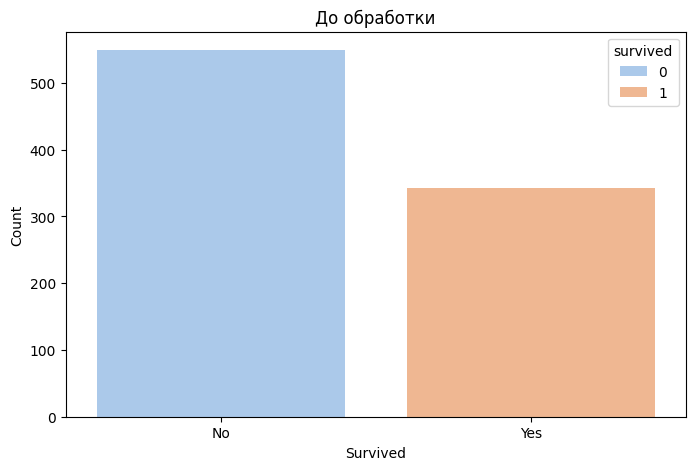

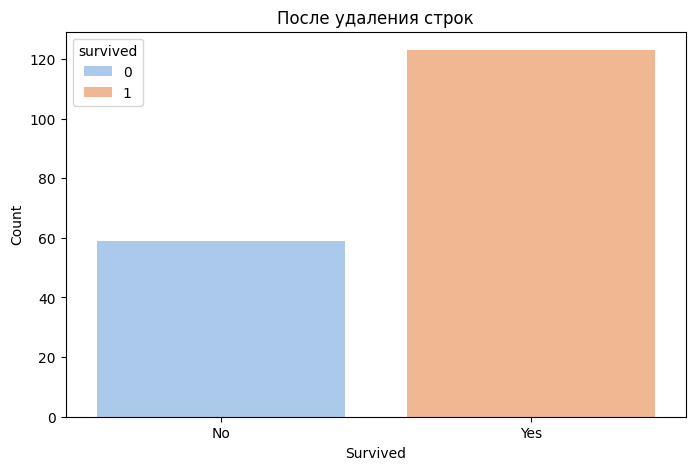

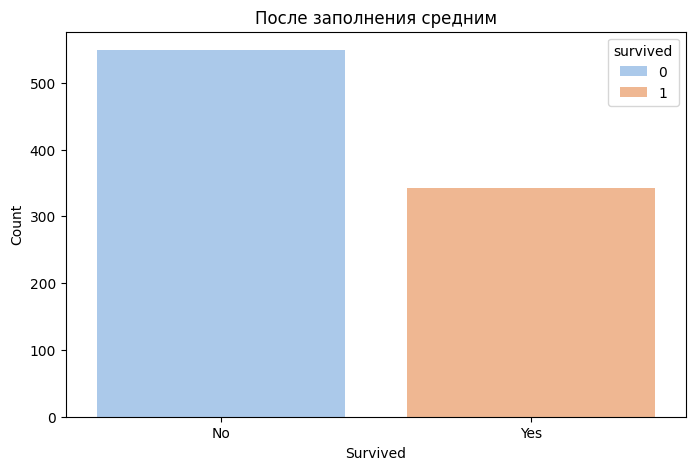

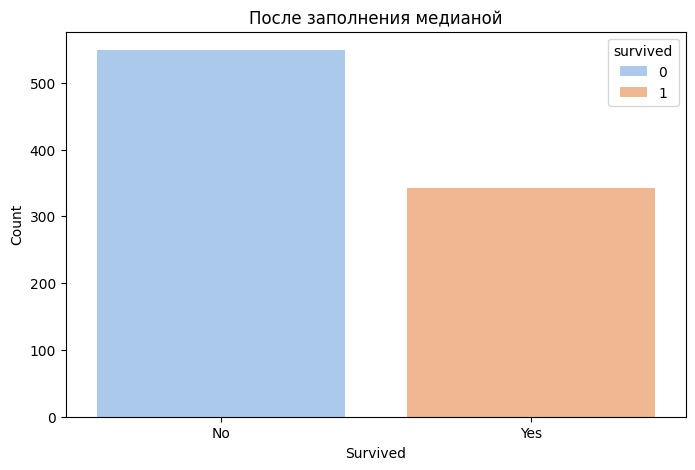

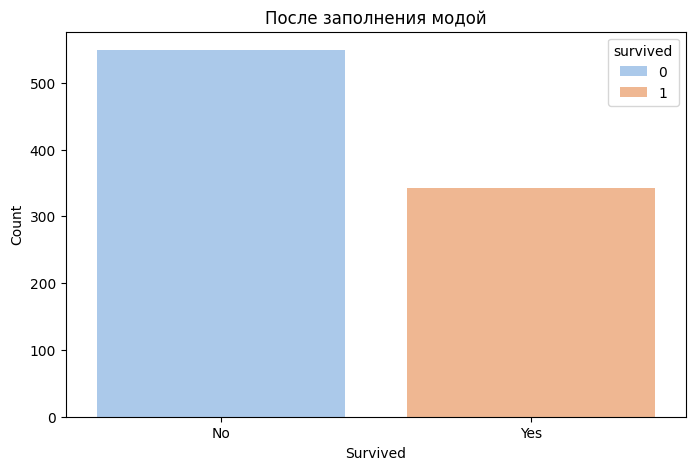

In [52]:
def plot_survival(data, title):
    plt.figure(figsize=(8, 5))
    sb.countplot(data=data, x='survived', hue='survived', palette='pastel')
    plt.title(title)
    plt.xlabel('Survived')
    plt.ylabel('Count')
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.show()

plot_survival(titanic, 'До обработки')
plot_survival(titanic_dropped, 'После удаления строк')
plot_survival(titanic_mean_filled, 'После заполнения средним')
plot_survival(titanic_median_filled, 'После заполнения медианой')
plot_survival(titanic_mode_filled, 'После заполнения модой')

Задание 5: Обработка пропущенных значений

Используя набор данных о пассажирах Титаника из библиотеки Seaborn (sns.load_dataset('titanic')), необходимо найти и обработать все пропущенные значения. Можно использовать различные методы (например, удаление, заполнение средним значением или медианой). Сравнить результаты.


In [53]:
data_5 = pd.read_csv('data/winequality-red.csv')

Let us Define features for normalization and standardization, then Apply normalization (Min-Max) (brings values to the range [0;1]) with Application of standardization (Z-score)
(brings the values to a standard normal distribution with mean=0, standard deviation=1)

In [54]:
features = data_5.select_dtypes(include=['float64', 'int64']).columns
min_max_scaler = MinMaxScaler()
data_normalized = data_5.copy()
data_normalized[features] = min_max_scaler.fit_transform(data_5[features])
standard_scaler = StandardScaler()
data_standardized = data_5.copy()
data_standardized[features] = standard_scaler.fit_transform(data_5[features])

Visualization of normalization results

from Original data to Normalized data and Standardized data

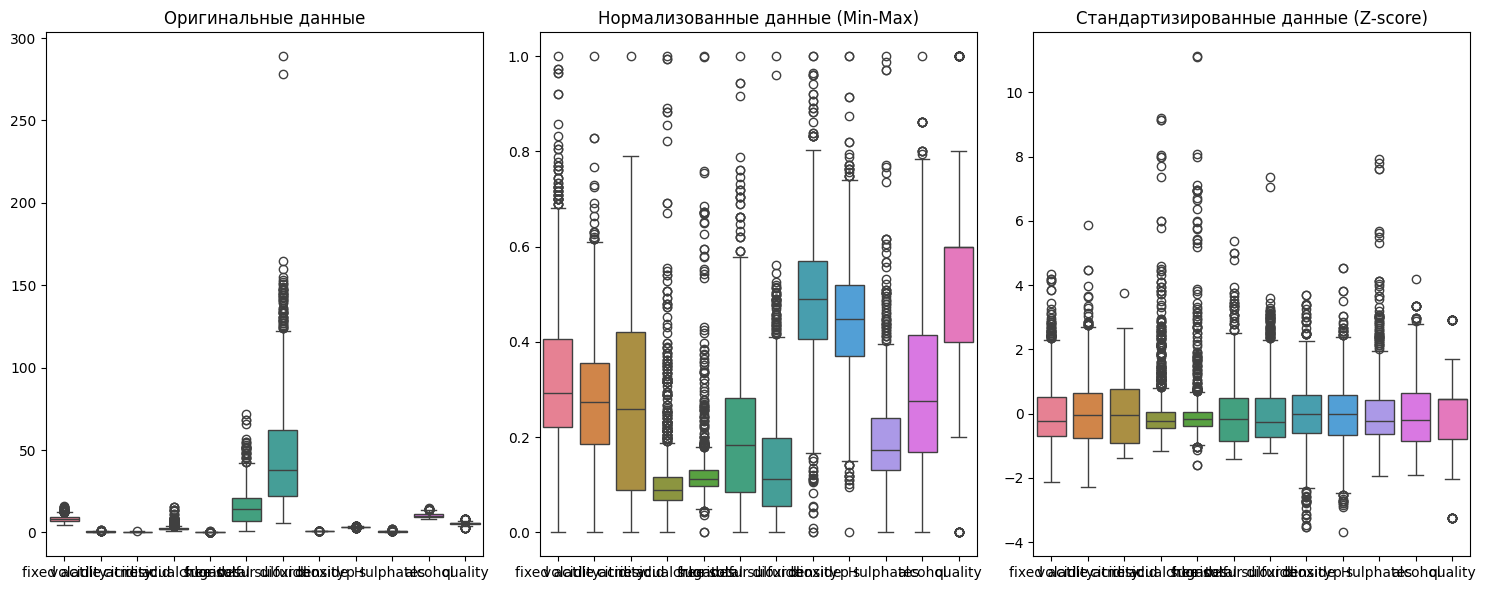

In [56]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sb.boxplot(data=data_5[features])
plt.title('Оригинальные данные')
plt.subplot(1, 3, 2)
sb.boxplot(data=data_normalized[features])
plt.title('Нормализованные данные (Min-Max)')
plt.subplot(1, 3, 3)
sb.boxplot(data=data_standardized[features])
plt.title('Стандартизированные данные (Z-score)')
plt.tight_layout()
plt.show()

Задание 6: Нормализация и стандартизация признаков датасета "Red Wine Quality"

Для набора данных о качестве красного вина ([ссылка на данные](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009)) примените различные методы нормализации и стандартизации к признакам, сравните результаты их применения.


In [57]:
data_6 = pd.read_csv('data/train.csv')

Selecting numerical variables then comoute correlations

In [58]:
numerical_features = data_6.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data_6[numerical_features].corr()

Visualization of correlations

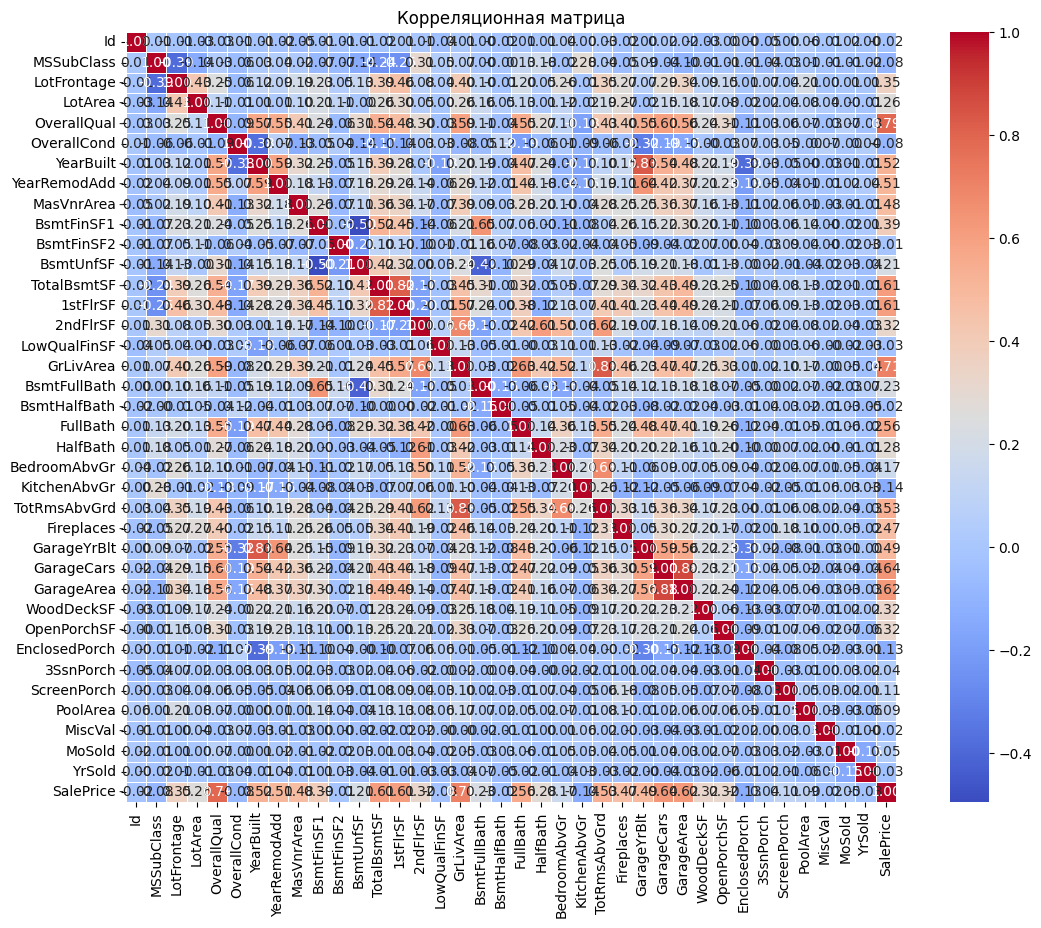

In [59]:
plt.figure(figsize=(14, 10))
sb.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, linewidths=.5)
plt.title('Корреляционная матрица')
plt.show()

Highlighting strong correlations


In [60]:
threshold = 0.5  # Threshold for strong correlation
strong_correlations = correlation_matrix[correlation_matrix.abs() > threshold]
print("Сильные корреляции:")
print(strong_correlations)

Сильные корреляции:
                Id  MSSubClass  LotFrontage  LotArea  OverallQual  \
Id             1.0         NaN          NaN      NaN          NaN   
MSSubClass     NaN         1.0          NaN      NaN          NaN   
LotFrontage    NaN         NaN          1.0      NaN          NaN   
LotArea        NaN         NaN          NaN      1.0          NaN   
OverallQual    NaN         NaN          NaN      NaN     1.000000   
OverallCond    NaN         NaN          NaN      NaN          NaN   
YearBuilt      NaN         NaN          NaN      NaN     0.572323   
YearRemodAdd   NaN         NaN          NaN      NaN     0.550684   
MasVnrArea     NaN         NaN          NaN      NaN          NaN   
BsmtFinSF1     NaN         NaN          NaN      NaN          NaN   
BsmtFinSF2     NaN         NaN          NaN      NaN          NaN   
BsmtUnfSF      NaN         NaN          NaN      NaN          NaN   
TotalBsmtSF    NaN         NaN          NaN      NaN     0.537808   
1stFlrSF      

Задание 7: Применение описательной статистики и корреляционного анализа для датасета "House Prices"

На данных о ценах на жилье ([ссылка на данные](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data)) рассчитайте основные метрики описательной статистики для числовых переменных и рассчитайте корреляции между переменными. Визуализируйте корреляции с помощью тепловых карт и обратите внимание на сильные корреляции.


In [61]:
data_7 = pd.read_csv('data/Tweets.csv')

Loading a list of stop words then build a function to delete them as we apply it to the culumn 'text'

In [62]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop_words])

data_7['cleaned_text'] = data_7['text'].apply(remove_stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Loading the stemmer, Build a Function for stamping then apply it

Loading the lemmatizer, build A function for lemmatization then apply it Application of lemmatization




In [63]:
stemmer = PorterStemmer()
def stem_words(text):
    words = text.split()
    return ' '.join([stemmer.stem(word) for word in words])

data_7['stemmed_text'] = data_7['cleaned_text'].apply(stem_words)
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize_words(text):
    words = text.split()
    return ' '.join([lemmatizer.lemmatize(word) for word in words])

data_7['lemmatized_text'] = data_7['cleaned_text'].apply(lemmatize_words)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Text vectorization using Conversion to Data Frame for convenience then View vectorized data

In [64]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_7['lemmatized_text'])
X_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(X_df.head())

   00  000  000114  000419  000ft  000lbs  0011  0016  00a  00am  ...  \
0   0    0       0       0      0       0     0     0    0     0  ...   
1   0    0       0       0      0       0     0     0    0     0  ...   
2   0    0       0       0      0       0     0     0    0     0  ...   
3   0    0       0       0      0       0     0     0    0     0  ...   
4   0    0       0       0      0       0     0     0    0     0  ...   

   zrh_airport  zsdgzydnde  zsuztnaijq  ztrdwv0n4l  zukes  zurich  zv2pt6trk9  \
0            0           0           0           0      0       0           0   
1            0           0           0           0      0       0           0   
2            0           0           0           0      0       0           0   
3            0           0           0           0      0       0           0   
4            0           0           0           0      0       0           0   

   zv6cfpohl5  zvfmxnuelj  zzps5ywve2  
0           0           0         

Задание 8: Обработка текстовых данных в датасете "Twitter Airline Sentiment"

Набор данных "Twitter Airline Sentiment" на Kaggle ([ссылка на данные](https://www.kaggle.com/crowdflower/twitter-airline-sentiment)) содержит реальные твиты о различных авиакомпаниях. Примените техники предобработки текста, вроде удаления стоп-слов, стемминга, лемматизации и векторизации для подготовки данных к анализу.


In [25]:
data = pd.read_csv('data/Tweets.csv')
data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [26]:
import re
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [28]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|@\S+|[^a-zA-Z\s]", '', text)
    words = text.split()
    words = [lemmatizer.lemmatize(stemmer.stem(word)) for word in words if word not in stop_words]

    return ' '.join(words)

In [30]:
data['processed_text'] = data['text'].apply(preprocess_text)
data['text']

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...
...,...
14635,@AmericanAir thank you we got on a different f...
14636,@AmericanAir leaving over 20 minutes Late Flig...
14637,@AmericanAir Please bring American Airlines to...
14638,"@AmericanAir you have my money, you change my ..."


In [31]:
data['processed_text']

,processed_text
0,said
1,plu youv ad commerci experi tacki
2,didnt today must mean need take anoth trip
3,realli aggress blast obnoxi entertain guest fa...
4,realli big bad thing
...,...
14635,thank got differ flight chicago
14636,leav minut late flight warn commun minut late ...
14637,plea bring american airlin blackberri
14638,money chang flight dont answer phone suggest m...


In [33]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['processed_text'])
pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

,aa,aaaand,aaadvantag,aaalwaysl,aaba,aacom,aadavantag,aadelay,aadfw,aadv,...,zigzag,zip,zipper,zombi,zone,zoom,zrh,zuke,zurich,zurichnew
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14636,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14637,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14638,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
